# Loan recommendation with Collaborative Filtering

The rating data is in loan_rating.csv, containing lender_id, loan_id, rating. Rating can be from 0-10.

In [1]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import random
import csv
from sklearn.model_selection import train_test_split
import locale # for currency formatting
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

os.chdir(r"D:\MATH 5671\Group 7\Assignment 7")

loan_rating_df = pd.read_csv("loan_rating.csv",header =0)
loan_rating_df.head()

,lender_id,loan_id,rating
0,0,0,3
1,1,0,0
2,2,0,0
3,3,0,0
4,4,0,2


In [2]:
n_lenders = len(loan_rating_df['lender_id'].unique())
n_loans = len(loan_rating_df['loan_id'].unique())

Now a recommender system model from scratch

In [3]:
lenders = loan_rating_df['lender_id'].unique()
n_lenders = len(lenders)
loans = loan_rating_df['loan_id'].unique()
n_loans = len(loans)
Y = np.empty([n_loans, n_lenders])
limit = 100

for loan in loans[:limit]:
    for lender in lenders:
        rating = loan_rating_df[loan_rating_df['loan_id'] == loan][loan_rating_df['lender_id'] == lender]['rating']
        if len(rating) == 0:
            Y[loan,lender] = -1
        else:
            Y[loan,lender] = rating.values[0]
        
        Y = Y.astype(float)

# use just part of Y (like, 100 loans)
Y = Y[:limit,:]
R = (Y != -1)
R = R.astype(float)

In [4]:
pd.DataFrame(Y, columns = ['lender_' + str(i) for i in range(len(Y[0]))], index = ['loan_' + str(i) for i in range(len(Y))]).head()

,lender_0,lender_1,lender_2,lender_3,lender_4,lender_5,lender_6,lender_7,lender_8,lender_9
loan_0,3.0,0.0,0.0,0.0,2.0,0.0,0.0,6.0,0.0,0.0
loan_1,4.0,6.0,0.0,0.0,2.0,7.0,0.0,0.0,9.0,4.0
loan_2,0.0,0.0,0.0,8.0,4.0,8.0,0.0,0.0,0.0,0.0
loan_3,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
loan_4,0.0,4.0,0.0,1.0,0.0,0.0,7.0,7.0,4.0,4.0


In [5]:
loan_df = pd.read_csv("loan.csv",header =0)
loan_df.head()
info = np.array(loan_df)[:limit,:]
loan_df.head()

,loan_amnt,term,int_rate,emp_length,home_ownership,annual_inc,purpose,addr_state,dti,delinq_2yrs,revol_util,total_acc,bad_loan,longest_credit_length,verification_status
0,5000,36 months,10.65,10.0,RENT,24000.0,credit_card,AZ,27.65,0.0,83.7,9.0,0,26.0,verified
1,2500,60 months,15.27,0.0,RENT,30000.0,car,GA,1.00,0.0,9.4,4.0,1,12.0,verified
2,2400,36 months,15.96,10.0,RENT,12252.0,small_business,IL,8.72,0.0,98.5,10.0,0,10.0,not verified
3,10000,36 months,13.49,10.0,RENT,49200.0,other,CA,20.00,0.0,21.0,37.0,0,15.0,verified
4,5000,36 months,7.90,3.0,RENT,36000.0,wedding,AZ,11.20,0.0,28.3,12.0,0,7.0,verified


Starting here write your own code in these functions

In [8]:
def costFun(param, Y, r, n_lenders, n_loans, n_features, lamba):
    # Write your code here
    
    X = param[0 : (n_loans * n_features)].reshape([n_loans, n_features], order = "F")
    Theta = param[(n_loans * n_features) :].reshape([n_lenders, n_features], order = "F")    
        
    J1 = J2 = J3 =  0.0

    for i in range(n_loans):
        for j in range(n_lenders):
            if (r[i,j]==1):
                J1 = J1 + (np.dot(Theta[j,:].T,X[i,:]) - Y[i,j])**2
    J1 /= 2
    
    for k in range(n_loans):
        for l in range(n_features):
            J2 = J2 + (X[k,l])**2
    J2 = J2*(lamba)/2
    
    for i in range(n_lenders):
        for j in range(n_features):
            J3 += (Theta[i,j])**2
    J3 = J3*(lamba)/2

    return J1 + J2 + J3 

def cost_grad(param, Y, r, n_lenders, n_loans, n_features, lamba):    
    
    # Write your code here

    X = param[0 : (n_loans * n_features)].reshape([n_loans, n_features], order = "F")
    theta = param[(n_loans * n_features) :].reshape([n_lenders, n_features], order = "F")
    
    # gradients
    X_grad = ((X @ theta.T - Y) * r) @ theta + (lamba * X)
    Theta_grad = ((X @ theta.T  - Y) * r).T @ X + (lamba * theta)
    grad = [X_grad[:],Theta_grad[:]]  

    return grad
    
def optimizeCost(param, Y, r, n_lenders, n_loans, n_features, lamba, step, maxrun):
    # Write your code here

    X = param[0 : (n_loans * n_features)].reshape([n_loans, n_features], order = "F")
    Theta = param[(n_loans * n_features) :].reshape([n_lenders, n_features], order = "F")
    
    costRange = []  
  
    c = costFun(param, Y, r, n_lenders, n_loans, n_features, lamba)
    costRange.append(c)

    
    X1 = np.zeros(np.shape(X))
    Theta1 = np.zeros(np.shape(Theta))
    
    w =0
    
    while (w < maxrun):
        
        [X_grad,Theta_grad] = cost_grad(param, Y, r, n_lenders, n_loans, n_features, lamba)
        
        for i in range(n_features):
            for j in range(n_loans):
                X1[j,i] = X[j,i] - step * X_grad[j,i]
                
            for k in range(n_lenders):
                Theta1[k,i] = Theta[k,i] - step * Theta_grad[k,i]
                
        param1 = np.concatenate((X1.reshape(n_loans * n_features, 1, order = "F"),
                             Theta1.reshape(n_lenders * n_features, 1, order = "F")))
        param1 = np.squeeze(param1)
        
        c1 = costFun(param1, Y, r, n_lenders, n_loans, n_features, lamba)
        costRange.append(c1)
        X = X1
        Theta = Theta1
        param = param1
        w += 1
        
    return param,costRange


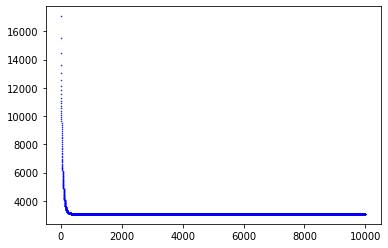


Top 3 recommendations for lender 1:

Predicted rating 6.8 for loan of  15000.0  for 36 months with credit_card purpose at 9.9 percent interest

Predicted rating 6.3 for loan of  9600.0  for 36 months with other purpose at 7.5 percent interest

Predicted rating 6.2 for loan of  12000.0  for 36 months with debt_consolidation purpose at 13.5 percent interest


Top 3 recommendations for lender 2:

Predicted rating 7.3 for loan of  31825.0  for 36 months with debt_consolidation purpose at 7.9 percent interest

Predicted rating 7.2 for loan of  6200.0  for 36 months with debt_consolidation purpose at 9.9 percent interest

Predicted rating 7.1 for loan of  6000.0  for 36 months with debt_consolidation purpose at 8.9 percent interest


Top 3 recommendations for lender 3:

Predicted rating 6.6 for loan of  15000.0  for 36 months with debt_consolidation purpose at 9.9 percent interest

Predicted rating 6.2 for loan of  31825.0  for 36 months with debt_consolidation purpose at 7.9 percent intere

In [9]:
n_lenders = np.size(Y, 1)
n_loans = np.size(Y, 0)
n_features = 10
# Initialization
X = np.random.normal(loc = 0.0, scale = 1.0, size = (n_loans, n_features))
Theta = np.random.normal(loc = 0.0, scale = 1.0, size = (n_lenders,n_features))
init_param = np.concatenate((X.reshape(n_loans * n_features, 1, order = "F"),
                             Theta.reshape(n_lenders * n_features, 1, order = "F")))
init_param = np.squeeze(init_param)

# Optimization
lamba = 10
maxrun = 10000
step = 0.001

param,cost_range = optimizeCost(init_param, Y, R, n_lenders, n_loans, \
                     n_features, lamba, step, maxrun)
# now plot the cost
plt.plot(cost_range,"b.",markersize=1,label="Cost") # note: this is 0-based
plt.show()
    
# Extract X and Theta from param vector
X = param[0:(n_loans * n_features)]
Theta = param[(n_loans * n_features):len(param)]
X = X.reshape(n_loans, n_features, order = "F")
Theta = Theta.reshape(n_lenders, n_features, order = "F")
pred = np.dot(X, Theta.T)

# print out top 3 ratings for each lender
top_n = 3
for j in range(n_lenders):
    rating = np.sort(pred[:, j])[::-1]
    ind = np.argsort(pred[:, j])[::-1]
    a = info[ind,:]
    print('\nTop %d recommendations for lender %d:\n' % (top_n, (j+1)))
    
    for i in range(top_n):
        print('Predicted rating %.1f for loan of  %s  for %s with %s purpose at %.1f percent interest\n' %
        (rating[i], np.float(a[i, 0]), a[i, 1], a[i, 6], np.float(a[i,2])))